In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# check files are there
!ls '/content/gdrive/My Drive/ch_train_set/'

a440  a45f  a476  a4e5	a548  a5c9  a658  a6d5	a8a7  a977  ab42  b0aa	b773
a447  a464  a4a3  a4e8	a558  a5ce  a668  a6db	a8ad  a9ce  ab48  b0ea	b944
a448  a467  a4a4  a4e9	a55b  a5d0  a67e  a6e6	a8ae  a9d2  ac46  b160	bb44
a44a  a46a  a4a7  a4eb	a569  a5d5  a6a8  a6e7	a8bd  a9fa  acdb  b16f	bb50
a451  a46b  a4bd  a4ec	a56b  a5db  a6b3  a6e8	a8c3  aa46  ad78  b1d0	bec7
a453  a46c  a4c0  a4f1	a57e  a5df  a6b8  a740	a8c6  aa47  adab  b3a3
a454  a470  a4ce  a4f4	a5a6  a5fd  a6b9  a751	a8d3  aacc  adfb  b3bd
a455  a473  a4d1  a4fb	a5aa  a5fe  a6ca  a7da	a8e0  aaf7  ae61  b3be
a457  a474  a4d2  a4fd	a5bf  a650  a6d1  a86b	a8e2  aaf8  afe0  b54c
a45d  a475  a4e2  a540	a5c1  a656  a6d3  a8a3	a8e4  aaf9  b0a8  b6c0


In [0]:
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, InputLayer
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, MaxPool2D
from keras import regularizers, optimizers
from keras.optimizers import SGD, Adam
from keras import Model, Input

from imageio import imread
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import pickle 

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

Using TensorFlow backend.


1.14.0


# Data Preprocessing
## Create a dataframe of image paths 

In [0]:
# crawl folder for images
def get_folders(root_dir):
  f = []
  for item in os.listdir(path):
      if os.path.join(path, item):
          f.append(path+item)
          
  return f
      
def get_files(root_dir):
  f = []
  for root, _, filenames in os.walk(path):
    for filename in filenames:
      f.append(os.path.join(root, filename))
      
  return f

path = '/content/gdrive/My Drive/ch_train_set/'
folders = get_folders(path)
files = get_files(path) 

In [0]:
# save paths to csv and load csv instead of crawling each time
paths_df = pd.DataFrame({'files':files})
#paths_df.to_csv('give folder here',index=False)

## Add script and label columns

In [0]:
df = pd.DataFrame(files, columns=['filename'])
# get rid of junk files
df = df[df.filename.str.split('/').str[-1] != '.DS_Store']
df['labels'] = df.filename.str.split('/').str[-1].str[0:4]
df.tail()

,filename,labels
8278,/content/gdrive/My Drive/ch_train_set/a46a/a46...,a46a
8279,/content/gdrive/My Drive/ch_train_set/a46a/a46...,a46a
8280,/content/gdrive/My Drive/ch_train_set/a46a/a46...,a46a
8281,/content/gdrive/My Drive/ch_train_set/a46a/a46...,a46a
8282,/content/gdrive/My Drive/ch_train_set/a46a/a46...,a46a


In [0]:
df['script'] = np.where(df.filename.str.split('/').str[-1].str.split('-').str[1].str.split('_').str[0].isna() == True, "modern", 
         df.filename.str.split('/').str[-1].str.split('-').str[1].str.split('_').str[0])

df.head(10)

,filename,labels,script
1,/content/gdrive/My Drive/ch_train_set/a44a/a44...,a44a,jinwen
2,/content/gdrive/My Drive/ch_train_set/a44a/a44...,a44a,jinwen
3,/content/gdrive/My Drive/ch_train_set/a44a/a44...,a44a,jinwen
4,/content/gdrive/My Drive/ch_train_set/a44a/a44...,a44a,chuxi
5,/content/gdrive/My Drive/ch_train_set/a44a/a44...,a44a,jinwen
6,/content/gdrive/My Drive/ch_train_set/a44a/a44...,a44a,oracle
7,/content/gdrive/My Drive/ch_train_set/a44a/a44...,a44a,modern
8,/content/gdrive/My Drive/ch_train_set/a44a/a44...,a44a,jinwen
9,/content/gdrive/My Drive/ch_train_set/a44a/a44...,a44a,jinwen
10,/content/gdrive/My Drive/ch_train_set/a44a/a44...,a44a,jinwen


In [0]:
# find max size of group
#max_size = df['labels'].value_counts().max()

# upsample
#lst = [df]
#for class_index, group in df.groupby('labels'):
#    lst.append(group.sample(max_size-len(group), replace=True))
#df_new = pd.concat(lst)

## Subsample data

For the prototype, I filter the dataset down to Jinwen era characters.

In [0]:
df_sample = df[df.script == 'jinwen']
#df_sample.labels.value_counts()

In [0]:
pd.options.mode.chained_assignment = None  # default='warn'
df_sample['duplicated'] = df_sample[['labels']].duplicated(keep='first')

In [0]:
df1 = df_sample[df_sample['duplicated'] == False ] # get one unique example from each class
df_dup = df_sample[df_sample['duplicated'] == True ]
df2 = df_dup[df_dup.index % 2 != 0].sample(frac=1)  # Excludes every 3rd row starting from 0, shuffle these
df3 = df_dup[df_dup.index % 2 == 0].sample(frac=1)  # Selects every 3rd row starting from 0, shuffle these  
df_shuffle = pd.concat([df3,df2,df1])

In [0]:
# check how many rows exist after filtering
df_shuffle.shape

(3809, 4)

In [0]:
#df.labels.drop_duplicates()

## Split into train, valid, and test data

In [0]:
# augment images
datagen = ImageDataGenerator(
    rescale=1./255. )#,
#    rotation_range=5,
#    width_shift_range=0.05,
#   height_shift_range=0.05,
#    horizontal_flip=False)


# augment images
valid_datagen = ImageDataGenerator(
    rescale=1./255. )#,
#    rotation_range=5,
#    width_shift_range=0.05,
#    height_shift_range=0.05,
#    horizontal_flip=False)

test_datagen=ImageDataGenerator(rescale=1./255.)


train_generator=datagen.flow_from_dataframe(
  dataframe=df_shuffle[:3000],
  directory='/content/',
  x_col="filename",
  y_col="labels",
  batch_size=25,
  seed=42,
  shuffle=True,
  class_mode='categorical', 
  target_size=(50,50))

valid_generator=valid_datagen.flow_from_dataframe(
  dataframe=df_shuffle[3300:],
  directory='/content/',
  x_col="filename",
  y_col="labels",
  batch_size=25,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=(50,50))


test_generator=test_datagen.flow_from_dataframe(
  dataframe=df_shuffle[3000:3300],
  directory="/content/",
  batch_size=25,
  seed=42,
  shuffle=False,
  class_mode=None,
  target_size=(50,50))



Found 3000 validated image filenames belonging to 120 classes.
Found 509 validated image filenames belonging to 120 classes.
Found 300 validated image filenames.


# Model Training - 3L CNN

## Model architecture

In [0]:
# create model

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(50,50,3)))
model.add(Conv2D(filters=32,kernel_size=5,strides=1,padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=5,padding='same'))

model.add(Conv2D(filters=80,kernel_size=5,strides=1,padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=5,padding='same'))

model.add(Conv2D(filters=50,kernel_size=5,strides=1,padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=5,padding='same'))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(120,activation='softmax'))

adam = Adam()
model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

W0822 16:13:31.631130 139735489836928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 16:13:31.694476 139735489836928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0822 16:13:31.703622 139735489836928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0822 16:13:31.778022 139735489836928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0822 16:13:31.815603 139735489836928 deprecation_wrapp

In [0]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df_shuffle.labels),
                                                 df_shuffle.labels)

## Model training

In [0]:
# train model
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20,
                    class_weight=class_weights)

W0822 16:13:32.847178 139735489836928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
120/120 [==============================] - 817s 7s/step - loss: 4.4800 - acc: 0.0377 - val_loss: 4.5125 - val_acc: 0.0320
Epoch 2/20
120/120 [==============================] - 778s 6s/step - loss: 4.0536 - acc: 0.1050 - val_loss: 3.8443 - val_acc: 0.1880
Epoch 3/20
120/120 [==============================] - 788s 7s/step - loss: 3.1933 - acc: 0.2583 - val_loss: 2.8572 - val_acc: 0.3554
Epoch 4/20
120/120 [==============================] - 783s 7s/step - loss: 2.6032 - acc: 0.3660 - val_loss: 2.5294 - val_acc: 0.4380
Epoch 5/20
120/120 [==============================] - 779s 6s/step - loss: 2.2366 - acc: 0.4403 - val_loss: 2.2771 - val_acc: 0.4793
Epoch 6/20
120/120 [==============================] - 787s 7s/step - loss: 1.9897 - acc: 0.4873 - val_loss: 1.9275 - val_acc: 0.5558
Epoch 7/20
120/120 [==============================] - 775s 6s/step - loss: 1.7417 - acc: 0.5467 - val_loss: 1.9012 - val_acc: 0.5620
Epoch 8/20
120/120 [==============================] - 771s 6s/step - 

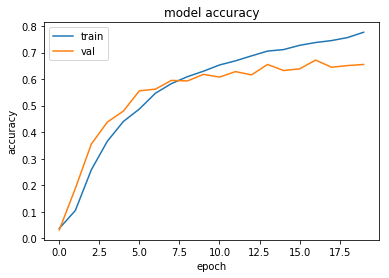

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
# save model weights
model.save('/content/gdrive/My Drive/chinese/model.h5')
model.save_weights('/content/gdrive/My Drive/chinese/model_weights.h5')

# save model json
model_json = model.to_json()
with open('/content/gdrive/My Drive/chinese/model.json', 'w') as json_file:
  json_file.write(model_json)

In [0]:
# load model
from keras.models import load_model

model = load_model('/content/gdrive/My Drive/chinese/model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50, 50, 512)       2048      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        409632    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 80)        64080     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 80)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 50)          100050    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 50)          0         
__________

# Validation

## Predict on test data

In [0]:

filenames = test_generator.filenames
nb_samples = len(filenames)

# make predictions on test data
predict = model.predict_generator(test_generator,steps = nb_samples/25) # nb_samples/batch size of test data

# get categories
predicted_class_indices=np.argmax(predict,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

# create df of results
filenames=test_generator.filenames
results=pd.DataFrame({"filename":filenames,
                      "predictions":predictions})

In [0]:
results['actual'] = results.filename.str.split('/').str[-1].str[:4]
results['correct'] = np.where(results.predictions==results.actual,1,0)
results.head()

,filename,predictions,actual,correct
0,/content/gdrive/My Drive/ch_train_set/a8e4/a8e...,a4eb,a8e4,0
1,/content/gdrive/My Drive/ch_train_set/a5ce/a5c...,a46b,a5ce,0
2,/content/gdrive/My Drive/ch_train_set/a45f/a45...,a8a3,a45f,0
3,/content/gdrive/My Drive/ch_train_set/a451/a45...,a7da,a451,0
4,/content/gdrive/My Drive/ch_train_set/a4e8/a4e...,a6db,a4e8,0


In [0]:
results.correct.value_counts()

1    225
0     75
Name: correct, dtype: int64

## Calculate accuracy

In [0]:
print('Accuracy of predictions on test data:', (results.correct.sum() / results.shape[0])*100,'%.')

Accuracy of predictions on test data: 75.0 %.


In [0]:
#results[results.correct == 0]

## Investigate misclassified characters

In [0]:
def sample_characters(character):
  w=100
  h=100
  fig=plt.figure(figsize=(8, 8))
  columns = 4
  rows = 1
  for i in range(1, columns*rows +1):
    filename = df_sample[df_sample.labels==character].filename.tolist()[i]
    img = mpimg.imread(filename)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
  plt.show()

/content/gdrive/My Drive/ch_train_set/a8e4/a8e4-jinwen_098.png


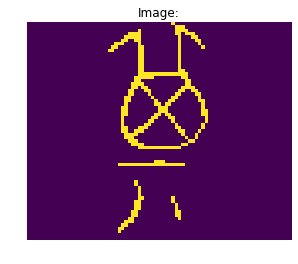

Predicted: a4eb 月


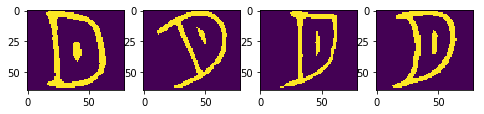

Actual: a8e4 其


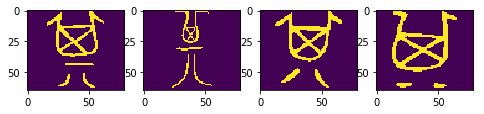

----------------------------------------
/content/gdrive/My Drive/ch_train_set/a5ce/a5ce-jinwen_011.png


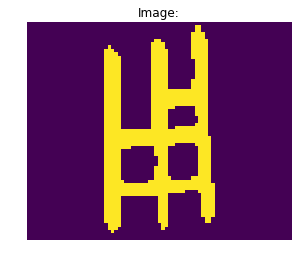

Predicted: a46b 女


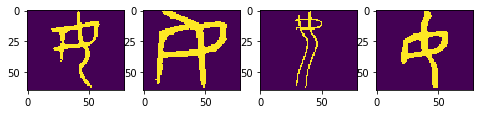

Actual: a5ce 用


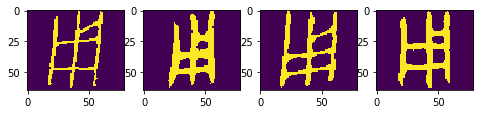

----------------------------------------
/content/gdrive/My Drive/ch_train_set/a45f/a45f-jinwen_061.png


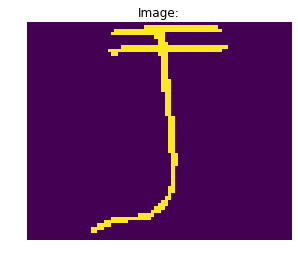

Predicted: a8a3 見


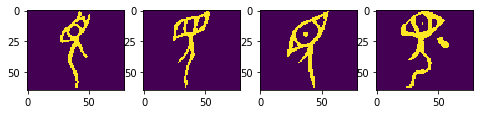

Actual: a45f 于


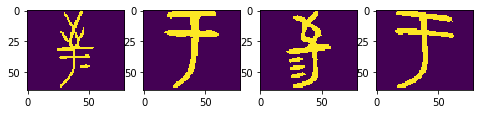

----------------------------------------


In [0]:
# Let's visualize the a few incorrect images
n = 0

for index, row in results[results.correct == 0].iterrows():
  print(row.filename)
  img=mpimg.imread(row.filename)
  imgplot = plt.imshow(img)
  plt.title('Image:')
  plt.axis('off')
  plt.show()
  
  print('Predicted:', row.predictions, bytes.fromhex(row.predictions).decode('big5'))
  sample_characters(row.predictions)
  print('Actual:', row.actual, bytes.fromhex(row.actual).decode('big5'))
  sample_characters(row.actual)
  
  print('----------------------------------------')

  n+=1
  if n==3:
    break

## Look at correctly classified characters

/content/gdrive/My Drive/ch_train_set/a5ce/a5ce-jinwen_009.png


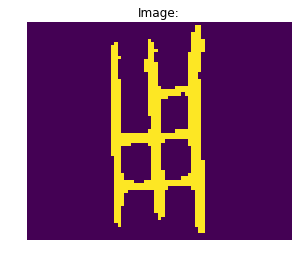

Correctly predicted: 用


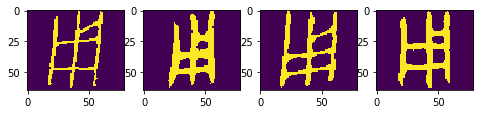

----------------------------------------
/content/gdrive/My Drive/ch_train_set/a6db/a6db-jinwen_000.png


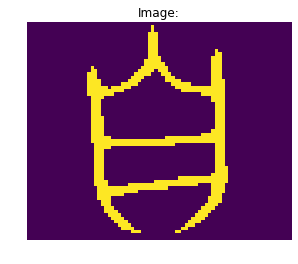

Correctly predicted: 自


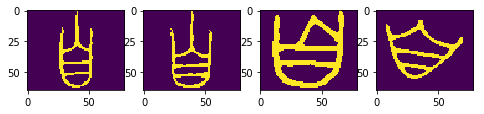

----------------------------------------
/content/gdrive/My Drive/ch_train_set/a5ce/a5ce-jinwen_109.png


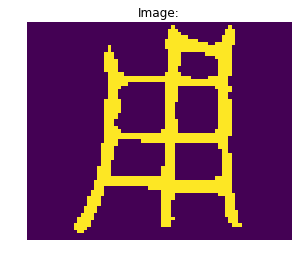

Correctly predicted: 用


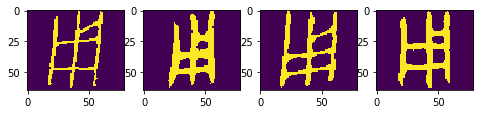

----------------------------------------


In [0]:
n = 0

for index, row in results[results.correct == 1].iterrows():
  print(row.filename)
  img=mpimg.imread(row.filename)
  imgplot = plt.imshow(img)
  plt.title('Image:')
  plt.axis('off')
  plt.show()
  
  print('Correctly predicted:', bytes.fromhex(row.predictions).decode('big5'))
  sample_characters(row.predictions)

  print('----------------------------------------')

  n+=1
  if n==3:
    break

# Identifying ancient Chinese text
I will put my model into action and predict the character of an image without labels.

In [0]:
path = '/content/gdrive/My Drive/chinese/holdout/character_classification/char_042.png'
path = '/content/gdrive/My Drive/chinese/holdout/character_classification/c4.png'


data = {'filename':[path]} 

df_holdout = pd.DataFrame(data) 
df_holdout.head(10)

,filename
0,/content/gdrive/My Drive/chinese/holdout/chara...


In [0]:

holdout_datagen=ImageDataGenerator(rescale=1./255.)

holdout_generator=holdout_datagen.flow_from_dataframe(
  dataframe=df_holdout,
  directory='/content/',
  x_col="filename",
  batch_size=1,
  seed=42,
  shuffle=True,
  class_mode=None,
  target_size=(50,50))


predict_img = model.predict_generator(holdout_generator,steps=1) 

# get categories
predicted_class_indices=np.argmax(predict_img,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

# create df of results
filenames=holdout_generator.filenames
results=pd.DataFrame({"filename":filenames,
                      "prediction":predictions})

results

Found 1 validated image filenames.


,filename,prediction
0,/content/gdrive/My Drive/chinese/holdout/chara...,a5d0


/content/gdrive/My Drive/chinese/holdout/character_classification/c4.png


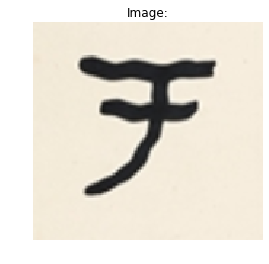

Predicting image as: 田


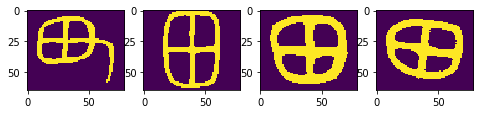

In [0]:
for index, row in results.iterrows():
  print(row.filename)
  img=mpimg.imread(row.filename)
  imgplot = plt.imshow(img)
  plt.title('Image:')
  plt.axis('off')
  plt.show()
  
  print('Predicting image as:', bytes.fromhex(row.prediction).decode('big5'))
  sample_characters(row.prediction)

In [0]:
results.predictions[0]

'a4eb'